### tests :

We would like to know why the algorithm calculates a lot of states near the intermediary states. 

Ideas: 
   - plot the fidelity towards the intermediary state. We will have 3 plots in the case where we have 
    3 intermediary states.
    
   - plot $\lambda$ vs time

In this notebook, we are searching a usecase for intermediary states. This mean that we would like to find a trajectory with intermediary states that follows the geodesic in a better way than a continuos trajectory

## Setup 3 with Python code

Without and with intermediary states.
At the end, one will find the plots comparing both results.

In [106]:
# libraries
import numpy as np
import matplotlib as mpl
from matplotlib import cm
from sympy.solvers import solve
from sympy import Symbol, symbols, Eq, Function, simplify

from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import qutip

import mayavi

In [107]:
## this cell is to have nice plots
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [108]:
# Declare variables as arrays
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma_y = np.array([[0.0, -1j], [1.0j, 0.0]])
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
iden = np.array([[1.0, 0.0], [0.0, 1.0]])
zero = np.array([[1.0], [0.0]])
uno = np.array([[0.0], [1.0]])
iden = np.array([[1.0,0.0],[0.0,1.0]])

In [109]:
## the geodesic function
def geo(te,ri,sf):
    '''This is the function for the geodesic'''
    ### INPUT 
    #te(int): the parameter of the geodesic. te \in [0,1]
    #ri(vector): numpy array with the coordinates of the ri quantum state
    #sf(vector): numpy array with the coordinates of the sf quantum state
    ### OUTPUT
    # a quantum state at te given by geodesic between ri and sf 
    #####################################
    # define the density matrices for the initial and final states
    rho1 = 0.5 * (iden + ri[0] * sigma_x + ri[1] * sigma_y + ri[2] * sigma_z)
    sigma2 = 0.5 * (iden + sf[0] * sigma_x + sf[1] * sigma_y + sf[2] * sigma_z)
    
    # calculate the square root and its inverse of each density matrix
    rootrho1 = np.sqrt(1 / (np.trace(rho1) + 2 * np.sqrt(np.linalg.det(rho1)))) * (rho1 + np.sqrt(np.linalg.det(rho1)) * iden)
    rootinverrho1 = np.linalg.inv(rootrho1)
    rootsigma2 = np.sqrt(1 / (np.trace(sigma2) + 2 * np.sqrt(np.linalg.det(sigma2)))) * (sigma2 + np.sqrt(np.linalg.det(sigma2)) * iden)
    rootinversigma2 = np.linalg.inv(rootsigma2)
    
    # calculate the root product of the geodesic, the fidelity, and theta
    rootproducto = (rootsigma2 @ rho1 @ rootsigma2 + np.sqrt(np.linalg.det(sigma2)) * np.sqrt(np.linalg.det(rho1)) * iden) / (np.trace(sigma2 @ rho1) + 2 * np.sqrt(np.linalg.det(sigma2)) * np.sqrt(np.linalg.det(rho1)))**0.5
    fide = np.trace(rho1 @ sigma2) + np.sqrt(1 - np.trace(rho1 @ rho1)) * np.sqrt(1 - np.trace(sigma2 @ sigma2))
    theta0 = np.arccos(np.sqrt(fide))
    
    
    # define a function for the geodesic
    
    return (np.cos(te * theta0) - np.sin(te * theta0) / np.tan(theta0))**2 * rho1 + (np.sin(te * theta0))**2 / (np.sin(theta0))**2 * sigma2 + (np.sin(te * theta0)) / (np.sin(theta0))*(np.cos(te*theta0)-(np.sin(te*theta0)/np.tan(theta0)))*(rootinversigma2@rootproducto@rootsigma2+rootsigma2@rootproducto@rootinversigma2) 


def muk(rk, s):
    """muk function of the algorithm
    """ 
    return (s - np.dot(rk, rk)*s - np.sqrt(1 - np.dot(rk, rk))*np.sqrt(1 - np.dot(s, s))*rk)/(2*(1 - np.dot(rk, rk))*np.sqrt(0.5*(1 + np.dot(rk, s) + np.sqrt((1 - np.dot(rk, rk))* (1 - np.dot(s, s))))))

def fidelity(rho, st):
    """This is the fidelity of two the states rho and st. rho and st are vectors
    """
    rho = np.squeeze(np.asarray(rho)) ## this line is import when are getting the time in the imax function
    return 0.5*(1 + np.dot(rho, st) + (1 - np.dot(rho, rho))**0.5*(1 - np.dot(st, st))**0.5)

def bloch_vector(rho):
    ''' 
    This functions takes a density matrix rho and we get the coordinates on the Bloch sphere
    '''
    sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
    sigma_y = np.array([[0.0, -1j], [1.0j, 0.0]])
    sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
    
    vec = np.array([np.trace(rho @ sigma_x),
                    np.trace(rho @ sigma_y),
                    np.trace(rho @ sigma_z)])
    #return vec / np.linalg.norm(vec) #not normzalized becuase it does not work
    return vec 


def delete_less_than_k(arr,k=1.0e-6):
    """Eliminate small numbers in a vector """
    for i in range(len(arr)):#Iterating the list arr
        Z = (arr[i].real, arr[i].imag)
        if abs(Z[0])<k:
            a=0
        else:
            a=Z[0]
        if abs(Z[1])<k:
            b=0.0j
        else:
            b=Z[1]
        
        arr[i]=a+b



In [110]:
def control1setup3(ri,sf,Nmax=60,w0=5,gamma_0 = 0.01,gamma_c = 10,deltat = 0.003,initime=0.0):
    """This function is control setup3 without imax
    """
    ###INPUT
    #ri(np.array): np.array[rix,riy,riz] initial quantum 
    #sf(np.array): np.array[rix,riy,riz] final quantum 
    #Nmax(int): Nmax iteration that will run the algorithm
    # ...
    #...t
    #....
    #OUTPUT
    #c(np.array): list containing the quantum states that will lead to the final state
    # tiempototal(np.array): list containing the time steps 
    # soln (solution of odes): solution of odes with parameter t
    #######################################
    lambda_x = Symbol('lambda_x', real=True) ## simbolic lambda for solving with sympy
    D_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 2]] ## Dmatrix of setup 3
    c=[ri]
    tiempototal=[initime]
    vector_lambda = list([])
    # iterate to find the lambda value
    helperk = 0
    #auxtime = 
    oldri = ri ## save the initial state ri
    #for k in range(Nmax):
    while ( (fidelity(oldri,sf)<=fidelity(ri,sf) ) and (helperk < Nmax) ):
        # calculate vk, ukx, uky, and ukz
        vk = lambda_x / 4.0 * (2.0 * muk(ri, sf)[2] - np.dot(ri, D_matrix @ muk(ri, sf)))
        ukx = lambda_x * np.cross(ri, muk(ri, sf))[0]
        uky = lambda_x * np.cross(ri, muk(ri, sf))[1]
        ukz = lambda_x * np.cross(ri, muk(ri, sf))[2]

        print(vk, ukx, uky, ukz)

        # solve for lambda
        solver1 = solve(vk**2 + ukx**2 + uky**2 + ukz**2 - gamma_c**2, lambda_x)
        
        lamdasol = solver1[1]
    
        vector_lambda.append(lamdasol)
        auxilvk = lamdasol / 4 * (2.0 * muk(ri, sf)[2] - np.dot(ri, D_matrix @ muk(ri, sf)))
        vk = auxilvk if auxilvk > 0 else 0
        ukx = lamdasol * np.cross(ri, muk(ri, sf))[0]
        uky = lamdasol * np.cross(ri, muk(ri, sf))[1]
        ukz = lamdasol * np.cross(ri, muk(ri, sf))[2]
    
        # Matrix for setup 3
        Bmatrix = np.array([[-2.0 * gamma_0 - vk / 2.0, -2.0 * (w0 + ukz), 2.0 * uky],
                            [2.0 * (w0 + ukz), -2.0 * gamma_0 - vk / 2.0, -2.0 * ukx],
                            [-2.0 * uky, 2.0 * ukx, -vk]])
        qk = [0.0, 0.0, vk] # qk setup3
        
        def odes(t,X):
            ## this function defines the differential equation
            rkx, rky, rkz = X
            drkx = (Bmatrix@[rkx,rky,rkz]+qk)[0]
            drky = (Bmatrix@[rkx,rky,rkz]+qk)[1]
            drkz = (Bmatrix@[rkx,rky,rkz]+qk)[2]
            return drkx, drky, drkz
        ## initial conditions of the ODE
        rkx0=ri[0]
        rky0=ri[1]
        rkz0=ri[2]
        # here we solve the ODE
        soln = solve_ivp(odes, (0.0, deltat), (rkx0, rky0, rkz0),dense_output=True)
        
        # replace to get x,y,z to plot on the Bloch sphere
        x, y, z = soln.sol(deltat)
        oldri = ri ## save the old ri
        ri = np.array([x,y,z]) ## update the ri 
        #print("Just checking-the new vector is:",ri)
        #print("Just checking-the vector to get:",sf)
        #print("Just checking-the old fidelity is:",fidelity(oldri,sf))
        #print("Just checking-the fidelity is:",fidelity(ri,sf))
        #print("Just checking-helperk=",helperk)
        c.append(ri)
        initime= initime + deltat
        #print(initime)
        tiempototal.append(initime)
        helperk += 1
    ### eliminate the final states    
    c = c[0:-1]
    tiempototal=tiempototal[0:-1]
    return c , tiempototal, soln, vector_lambda

In [111]:
def get_time_fidelity(c,tiempototal,soln,imax,sf,w0=5,gamma_0 = 0.01,gamma_c = 10):
    """This is the for loop that contains the imax. This function calculates the 
    time of the next evolution using the fidelity"""
    #### INPUT
    #c(list): numpy array that contains the quantum states until Nmax 
    #tiempotoal(list): numpy array that contains the time steps
    #soln(solution of odes): this is the solution of odes that come from the previous step
    #sf(list): final quantum states
    #imax(int): number of iterations in order to get the time with fidelity
    #..
    #..
    ###OUTPUT
    #c(list): list of quantum states that contains the evolution
    #tiempotoal(list): numpy array that contains the time steps
    #
    #########################################################
    # Time with Fidelity
    auxvar = len(c)
    aux2time = tiempototal[-1]
    lambda_x = Symbol('lambda_x') ## simbolic lambda for solving with sympy
    D_matrix = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 2.0]] ## Dmatrix of setup 3
    list_lambda=list([])
    for i in range(imax):
        print("Find time with fidelity")
        
        def func_to_optimize(t, soln):
            '''This is the fidelity that we want to optimize in order to get
            the time. Here, we are minimizing the -1*Fidelity'''
        ## INPUT
        # t(parameter): t is a parameter 
        #soln(solution of odes): this solution of odes come from the last step
        #OUTPUT
        # Fidelity that depends on parameter t
        #
            return (-1.0*fidelity(soln.sol(t),sf)) 
        
        res = minimize(func_to_optimize,[0.00000001],args=(soln),tol=1e-6)
        timeopt = res.x[0]/2.0 # time from fidelity
        
        aux2time += timeopt
        tiempototal.append(aux2time)
        
        print("new time:", timeopt)
        x1, y1, z1 = soln.sol(timeopt)
        rnew = np.array([x1,y1,z1])
        print("Fidelity", fidelity(rnew, sf))
        ri = rnew
        c.append(ri)
        
        
        ######################################### we have to use the control1setup3 function here
        print("New quantum state", ri)
        
        # calculate vk, ukx, uky, and ukz
        vk = lambda_x / 4.0 * (2.0 * muk(ri, sf)[2] - np.dot(ri, D_matrix @ muk(ri, sf)))
        ukx = lambda_x * np.cross(ri, muk(ri, sf))[0]
        uky = lambda_x * np.cross(ri, muk(ri, sf))[1]
        ukz = lambda_x * np.cross(ri, muk(ri, sf))[2]
        
        # solve for lambda
        solver1 = solve(vk**2 + ukx**2 + uky**2 + ukz**2- gamma_c**2, lambda_x)
        lamdasol = solver1[1]
        list_lambda.append(lamdasol)
        auxilvk = lamdasol / 4.0 * (2.0 * muk(ri, sf)[2] - np.dot(ri, D_matrix @ muk(ri, sf)))
        vk = auxilvk if auxilvk > 0 else 0
        ukx = lamdasol * np.cross(ri, muk(ri, sf))[0]
        uky = lamdasol * np.cross(ri, muk(ri, sf))[1]
        ukz = lamdasol * np.cross(ri, muk(ri, sf))[2]
        
         # Matrix for setup 3
        Bmatrix = np.array([[-2.0 * gamma_0 - vk / 2.0, -2.0 * (w0 + ukz), 2.0 * uky],
                            [2.0 * (w0 + ukz), -2.0 * gamma_0 - vk / 2.0, -2.0 * ukx],
                            [-2.0 * uky, 2.0 * ukx, -vk]])
        qk = [0.0, 0.0, vk]
        
        def odes(t,X):
            ## this function (internal) defines the differential equation
            
            rkx, rky, rkz = X
            drkx = (Bmatrix@[rkx,rky,rkz]+qk)[0]
            drky = (Bmatrix@[rkx,rky,rkz]+qk)[1]
            drkz = (Bmatrix@[rkx,rky,rkz]+qk)[2]
            return drkx, drky, drkz
        ## initial conditions of the ODE
        rkx0=ri[0]
        rky0=ri[1]
        rkz0=ri[2]
        
        # here we solve the ODE
        soln = solve_ivp(odes, (0, timeopt), (rkx0, rky0, rkz0),dense_output=True)
        
        # replace to get x,y,z to plot on the Bloch sphere
        x, y, z = soln.sol(timeopt)
        ri = np.array([x,y,z]) ## update the ri 
        
    return c, tiempototal, list_lambda

In [112]:
# Test values
#qsri = 1/np.sqrt(3)*np.array([1.0, 1.0, 0.9])
#qssf = np.array([0.0, 0.9, 0.0])
qsri = 1/np.sqrt(3)*np.array([0.7, 0.8, 0.8])
qssf = 1/np.sqrt(3)*np.array([0.2, 0.9, 0.0])
w0 = 5.0
gamma_0 = 0.01
gamma_c = 10
Nmax = 40
imax = 7
deltat = 0.0030

# Save initial and final states
auxri = qsri
auxsf = qssf

In [113]:
## testing cell
estadoslist, tiempolists, solution, vec_lambda = control1setup3(qsri,qssf,Nmax=Nmax,deltat=deltat)
tiempolists[-1]
vec_lambda

-0.0582870701872034*lambda_x -0.125493541381179*lambda_x 0.0278874536402619*lambda_x 0.0819193950682693*lambda_x
-0.0556002423016113*lambda_x -0.117683190919358*lambda_x 0.0261518202043017*lambda_x 0.0721846009312329*lambda_x
-0.0520771245666863*lambda_x -0.109459293329664*lambda_x 0.024324287406592*lambda_x 0.0622284467827921*lambda_x


-0.0476673334511893*lambda_x -0.100826316745359*lambda_x 0.0224058481656353*lambda_x 0.0521621687588136*lambda_x
-0.0423132327323075*lambda_x -0.0917800841281212*lambda_x 0.0203955742506936*lambda_x 0.0421057620376757*lambda_x
-0.0359459440806805*lambda_x -0.0823048949602026*lambda_x 0.0182899766578228*lambda_x 0.0321926022916464*lambda_x
-0.0284791542080535*lambda_x -0.0723695028681923*lambda_x 0.0160821117484872*lambda_x 0.0225777834847274*lambda_x
-0.019800708834394*lambda_x -0.0619226230165432*lambda_x 0.0137605828925651*lambda_x 0.0134538904237016*lambda_x
-0.00976777921183228*lambda_x -0.0508943738755654*lambda_x 0.0113098608612368*lambda_x 0.00508247020842599*lambda_x
0.00175059822701275*lambda_x -0.0392434126439701*lambda_x 0.00872075836532668*lambda_x -0.00214285516721082*lambda_x
0.0140836841271529*lambda_x -0.0275775384877554*lambda_x 0.00612834188616787*lambda_x -0.00760931966154427*lambda_x
0.021192056803019*lambda_x -0.0202371568907358*lambda_x 0.00449714597571907*lambda_

[61.2742005627058,
 66.1754754389770,
 72.2489523163035,
 79.9079104001009,
 89.7922670200548,
 102.939219395469,
 121.118307692969,
 147.492623432852,
 187.666770093428,
 248.164669292313,
 307.972473933609,
 316.921935515036,
 318.252597826855,
 324.880389404821,
 334.780035666073,
 346.905407804125,
 360.883774541796,
 376.584588786629,
 393.971075135170,
 413.053053804751,
 433.871968766903,
 456.496555179561,
 481.022512015951,
 507.574093711271,
 536.306953130847,
 567.412052702351,
 601.120675478032,
 637.710716483165,
 677.514580782044,
 720.929182658713,
 768.428748278504,
 820.581396670479,
 878.070849236814,
 941.725157035246,
 1012.55513465956,
 1091.80640669909,
 1181.03086838413,
 1282.18638206356,
 1397.77846199204,
 1531.06597588228]

In [114]:
## testing cell
finalestados, finaltiempotot, list_lambda_time=get_time_fidelity(estadoslist,tiempolists,solution,imax,qssf)
###
# take account that the bigger imax the better the fidelity. But the improvement in the fidelity 
# is very small

Find time with fidelity
new time: 0.01945084752749427
Fidelity 0.9995587750455428
New quantum state [0.11741943 0.55388071 0.00937498]


Find time with fidelity
new time: 0.0016425777715908594
Fidelity 0.99961716189696
New quantum state [1.16644382e-01 5.52467156e-01 2.36693851e-04]
Find time with fidelity
new time: 0.0006439842604807871
Fidelity 0.9996444428325884
New quantum state [0.11587857 0.55095577 0.00587538]
Find time with fidelity
new time: 0.008033276880205581
Fidelity 0.9998806360346184
New quantum state [0.12206023 0.53668009 0.00264056]
Find time with fidelity
new time: 0.00029909732844770714
Fidelity 0.9998890159586115
New quantum state [0.11876573 0.536802   0.00329892]
Find time with fidelity
new time: 0.0010145241152432515
Fidelity 0.9999070555615327
New quantum state [0.11410093 0.53584325 0.0025855 ]
Find time with fidelity
new time: 0.0019013352453517982
Fidelity 0.9999371545330138
New quantum state [0.11883319 0.53213949 0.00379673]


In [115]:
list_lambda_time

[3225.56232267747,
 2762.23861345996,
 3531.45453548314,
 6671.67704890057,
 8003.36679379859,
 5882.54179025206,
 9401.57327483188]

In [116]:
# radius
radius = [np.sqrt((finalestados[i][0])**2+(finalestados[i][1])**2+(finalestados[i][2])**2) for i in range(len(finalestados))]
listfidelities=[fidelity(finalestados[i],qssf) for i in range(len(finalestados))]

In [117]:
### plots

### bloch sphere
length = 1
nrm = mpl.colors.Normalize(0,length)
#colors = cm.winter(nrm(range(length))) # options: cool, summer, winter, autumn etc.
colors = cm.winter(range(length)) # options: cool, summer, winter, autumn etc.

b = qutip.Bloch(view=[170,50],figsize=[6,6])
b.sphere_alpha=0.2
b.point_color = ['r'] # options: 'r', 'g', 'b' etc.
b.point_marker = ['o']
b.point_size = [20]
for i in range(len(finalestados)):
    b.add_points(finalestados[i])
    
## ploting geodesic
Numbergeo = 250
geolist = [geo(t/Numbergeo,qsri,qssf) for t in range(Numbergeo+1)]
colors2 = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

vectorgeo = [bloch_vector(rho) for rho in geolist]
#b.point_color = ['b'] # options: 'r', 'g', 'b' etc.
#b.point_marker = ['*']
#b.point_size = [20]
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
    b.add_points(vectorgeo[i])

#b.add_points(auxri)
#b.add_points(auxsf)
newbloch=qutip.Bloch(view=[170,50],figsize=[6,6])
newbloch.point_color = ['b'] # options: 'r', 'g', 'b' etc.
newbloch.point_marker = ['*']
newbloch.point_size = [20]
newbloch.sphere_alpha=0.01
newbloch.frame_alpha=0.01
#newbloch.
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.

    newbloch.add_points(vectorgeo[i],'s')

In [118]:
#Mayavi is not working
#b3d = qutip.Bloch3d()


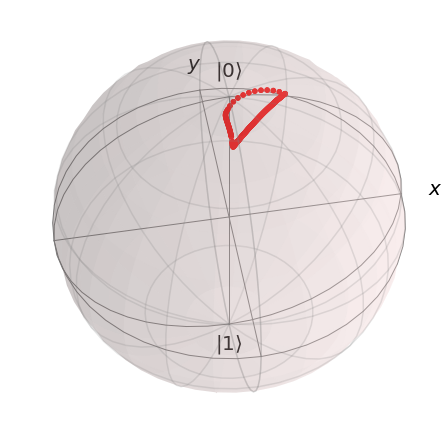

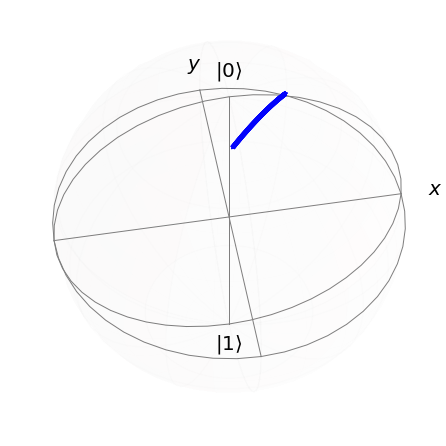

In [119]:
#improve plots

b.show()
newbloch.show()

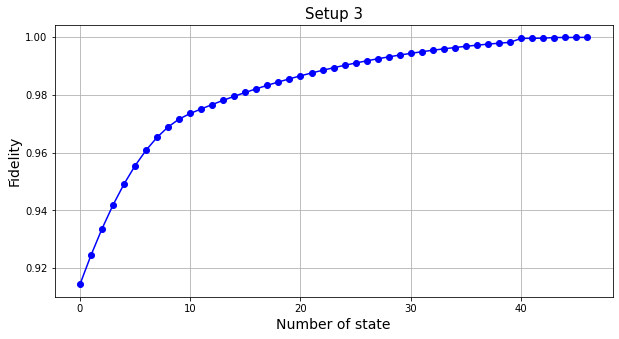

In [120]:
# data
xaxis = [i for i in range(len(finalestados))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, listfidelities, '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)

# show the plot
plt.show()

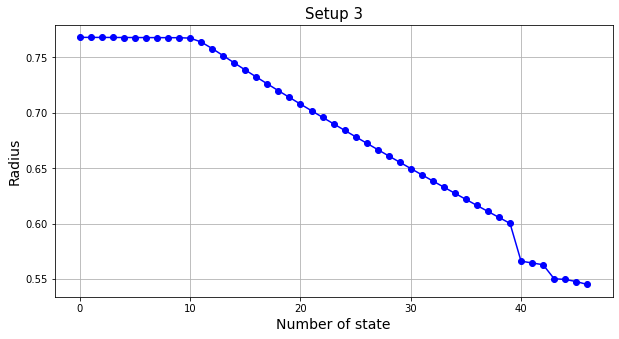

In [121]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,radius , '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Radius',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)

# show the plot
plt.show()

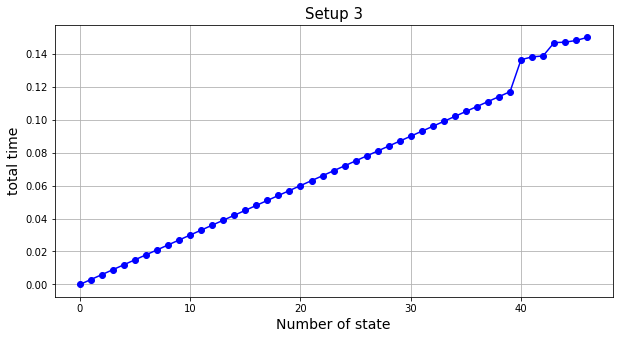

In [122]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,finaltiempotot, '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('total time',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)

# show the plot
plt.show()

In [123]:
list_lambda_time


[3225.56232267747,
 2762.23861345996,
 3531.45453548314,
 6671.67704890057,
 8003.36679379859,
 5882.54179025206,
 9401.57327483188]

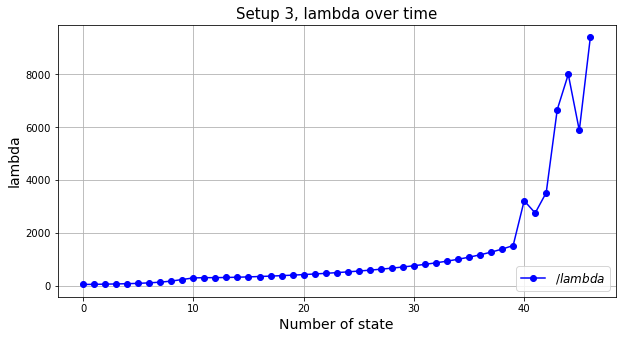

In [124]:
list_lambda =  vec_lambda+list_lambda_time
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, list_lambda, '-o', color='blue',label="$/lambda$")



#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('lambda',fontsize=14)
ax.set_title('Setup 3, lambda over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

## Testing with intermediary states

In the following cells we are going to use the geodesic that will give us some intermediary states in order to improve the control methodology

In [125]:
# Test values
#del(estadoslist, tiempolists, solution)
#qsri = 1/np.sqrt(3)*np.array([1.0, 1.0, 0.9])
#qssf = np.array([0.0, 0.9, 0.0])
qsri = 1/np.sqrt(3)*np.array([0.7, 0.8, 0.8])
qssf = 1/np.sqrt(3)*np.array([0.2, 0.9, 0.0])
w0 = 5

gamma_0 = 0.01
gamma_c = 10
Nmax = 30 ### with 20 is not working
imax = 7
deltat = 0.003

# Save initial and final states
auxri = qsri
auxsf = qssf

In [126]:
#numinter = 4 #number of intermediary states

numinter = 5 #number of intermediary states

#get the intermediary states from the geodesic
intermediaryqs=[geo((i)/(numinter-1),qsri,qssf) for i in range(numinter)]
intermediary = [bloch_vector(intermediaryqs[i]) for i in range(len(intermediaryqs)) ]
k = 1.0e-6
for i in range(numinter):
    delete_less_than_k(intermediary[i],k)

In [127]:
intermediary

[array([0.40414519+0.j, 0.46188022+0.j, 0.46188022+0.j]),
 array([0.34168337+0.j, 0.49297194+0.j, 0.3556096 +0.j]),
 array([0.27170149+0.j, 0.51321392+0.j, 0.24151243+0.j]),
 array([0.19573977+0.j, 0.52216066+0.j, 0.12209985+0.j]),
 array([0.11547005+0.j, 0.51961524+0.j, 0.        +0.j])]

In [128]:
solestes =[]
soltimes=[]
auxtime = 0.0
list_lambda = list([])
for i in range(numinter):
    #print("run",i)
    estadoslist, tiempolists, solution, lambdavec = control1setup3(qsri,intermediary[i],Nmax=Nmax,initime=auxtime)
    #print(estadoslist)
    solestes=solestes+estadoslist
    soltimes=soltimes+tiempolists
    qsri=estadoslist[-1]
    #print(tiempolists[-1])
    auxtime=tiempolists[-1]
    list_lambda=list_lambda+lambdavec

1.12368246409609e-17*lambda_x 3.12676859574564e-17*lambda_x -1.56338429787282e-17*lambda_x -1.17253822340461e-17*lambda_x
-0.0147746082224911*lambda_x -0.0318101064679513*lambda_x 0.00706891254843361*lambda_x 0.0207649306110237*lambda_x
-0.0100254753171878*lambda_x -0.0173864973702905*lambda_x 0.00691976061727531*lambda_x 0.0071129382177022*lambda_x
-0.00369984094988139*lambda_x -0.0029255436868408*lambda_x 0.00475979398836571*lambda_x -0.00378739845434087*lambda_x
0.00192577698340659*lambda_x 0.00515275419908868*lambda_x -0.00225431989772206*lambda_x -0.001825861681492*lambda_x
-0.0142954572962636*lambda_x -0.0304135342987995*lambda_x 0.00600152171648211*lambda_x 0.021461992438625*lambda_x
-0.00826073520654455*lambda_x -0.0181700639294397*lambda_x 0.00593103543162767*lambda_x 0.0078378716284109*lambda_x
-0.000231580187365625*lambda_x -0.00509144780185294*lambda_x 0.0042709845606244*lambda_x -0.0033479634142423*lambda_x
0.00882910565485431*lambda_x 0.00603071002999114*lambda_x -0.00177

In [129]:
list_lambda

[2.59426630347710e+17,
 241.731866935490,
 446.643406789588,
 1299.16531679228,
 1607.99092309703,
 247.994811070802,
 449.466401405568,
 1343.20014744079,
 889.053770434767,
 1036.55610254568,
 1132.13020750324,
 1050.96076700159,
 1045.55864534659,
 1095.02903883870,
 1043.93442905271,
 1065.81512714192,
 1080.73452945266,
 1074.71118224839,
 1072.50431458763,
 1080.22728460876,
 1081.62201986000,
 1076.99580062483,
 1092.51855619012,
 1080.62294492295,
 1096.50145565300,
 1082.40096219930,
 1104.20901479020,
 1083.19886809521,
 1111.29935113700,
 1085.28370110049,
 1117.19202883724,
 1086.80584371639,
 1123.78297490443,
 1088.26229425889,
 1129.96557037617,
 232.876793362729,
 379.395304358200,
 737.133946261140,
 669.351128386034,
 737.728373829247,
 756.426685747581,
 793.808695855729,
 820.747122457694,
 854.671325408163,
 885.727742412802,
 920.900730097295,
 955.318070740758,
 993.012339949200,
 1030.67388345415,
 1071.53652816398,
 1112.54434575789,
 1157.17284173202,
 1201.63

## Using the $i_{max}$ loop and intermediary states

In [130]:
estadoslist=solestes ## reuse the varaible 
tiempolists = soltimes ## reuse the variable
solestes, soltimes, vec_lambda_time=get_time_fidelity(estadoslist,tiempolists,solution,imax,qssf)
list_lambda = list_lambda + vec_lambda_time

Find time with fidelity
new time: 0.0005599309486068384
Fidelity 0.9996545576437601
New quantum state [ 0.11475278  0.55095985 -0.00068682]
Find time with fidelity
new time: 0.0006245402082342659
Fidelity 0.9996812258500787
New quantum state [0.11457774 0.54945808 0.0049648 ]
Find time with fidelity
new time: 0.0048434525991977425
Fidelity 0.9998194615988822
New quantum state [0.12223161 0.54003717 0.00816235]
Find time with fidelity
new time: 0.00029650137594062803
Fidelity 0.9998307848747463
New quantum state [0.11980898 0.54059164 0.00507314]
Find time with fidelity
new time: 0.0007433828525723951
Fidelity 0.9998481286829373
New quantum state [0.11599147 0.54035354 0.00199448]
Find time with fidelity
new time: 0.0009120223608173146
Fidelity 0.999867098373842
New quantum state [0.1161077  0.53831903 0.00634067]
Find time with fidelity
new time: 0.0004211871360470036
Fidelity 0.9998764513663663
New quantum state [0.11596728 0.53824979 0.00274223]


In [131]:
list_lambda

[2.59426630347710e+17,
 241.731866935490,
 446.643406789588,
 1299.16531679228,
 1607.99092309703,
 247.994811070802,
 449.466401405568,
 1343.20014744079,
 889.053770434767,
 1036.55610254568,
 1132.13020750324,
 1050.96076700159,
 1045.55864534659,
 1095.02903883870,
 1043.93442905271,
 1065.81512714192,
 1080.73452945266,
 1074.71118224839,
 1072.50431458763,
 1080.22728460876,
 1081.62201986000,
 1076.99580062483,
 1092.51855619012,
 1080.62294492295,
 1096.50145565300,
 1082.40096219930,
 1104.20901479020,
 1083.19886809521,
 1111.29935113700,
 1085.28370110049,
 1117.19202883724,
 1086.80584371639,
 1123.78297490443,
 1088.26229425889,
 1129.96557037617,
 232.876793362729,
 379.395304358200,
 737.133946261140,
 669.351128386034,
 737.728373829247,
 756.426685747581,
 793.808695855729,
 820.747122457694,
 854.671325408163,
 885.727742412802,
 920.900730097295,
 955.318070740758,
 993.012339949200,
 1030.67388345415,
 1071.53652816398,
 1112.54434575789,
 1157.17284173202,
 1201.63

In [132]:
### for plots using intermediary states

# radius and fidelities
radiusint = [np.sqrt((solestes[i][0])**2+(solestes[i][1])**2+(solestes[i][2])**2) for i in range(len(solestes))]
listfidelitiesint=[fidelity(solestes[i],qssf) for i in range(len(solestes))]

In [133]:
### fidelity using intermediary states

fide_inter_1 = [fidelity(solestes[i],intermediary[1]) for i in range(len(solestes))]
fide_inter_2 = [fidelity(solestes[i],intermediary[2]) for i in range(len(solestes))]
fide_inter_3 = [fidelity(solestes[i],intermediary[3]) for i in range(len(solestes))]

## Plots using intermediary states and setup 3

In [134]:
### plots

### bloch sphere
length = 1
nrm = mpl.colors.Normalize(0,length)
#colors = cm.winter(nrm(range(length))) # options: cool, summer, winter, autumn etc.
colors = cm.winter(range(length)) # options: cool, summer, winter, autumn etc.

b = qutip.Bloch(view=[170,10],figsize=[6,6])
b.sphere_alpha=0.2
b.point_color = ['r'] # options: 'r', 'g', 'b' etc.
b.point_marker = ['o']
b.point_size = [20]
for i in range(len(solestes)):
    b.add_points(solestes[i])
    
## ploting geodesic
Numbergeo = 250
geolist = [geo(t/Numbergeo,auxri,qssf) for t in range(Numbergeo+1)]
colors2 = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

vectorgeo = [bloch_vector(rho) for rho in geolist]
#b.point_color = ['b'] # options: 'r', 'g', 'b' etc.
#b.point_marker = ['*']
#b.point_size = [20]
#for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
#    b.add_points(vectorgeo[i])

#b.add_points(auxri)
#b.add_points(auxsf)
newbloch=qutip.Bloch(view=[170,30],figsize=[6,6])
newbloch.point_color = ['b'] # options: 'r', 'g', 'b' etc.
newbloch.point_marker = ['*']
newbloch.point_size = [20]
newbloch.sphere_alpha=0.01
newbloch.frame_alpha=0.01
#newbloch.
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
    newbloch.add_points(vectorgeo[i],'s')

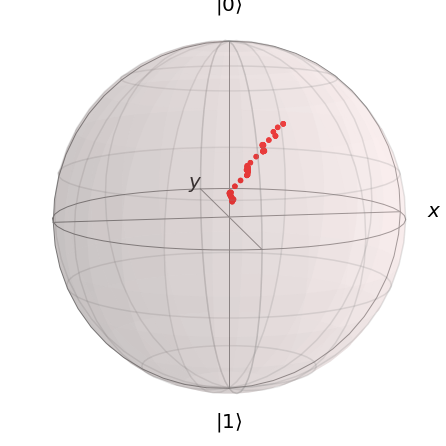

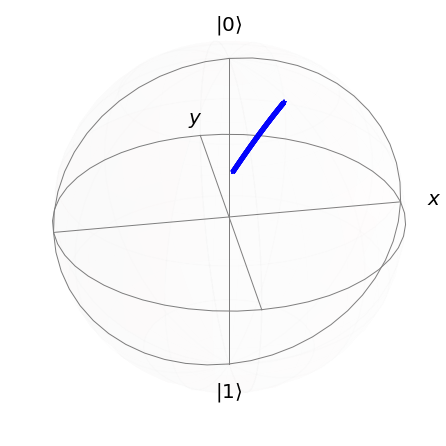

In [135]:
#improve plots
b.show()
newbloch.show()

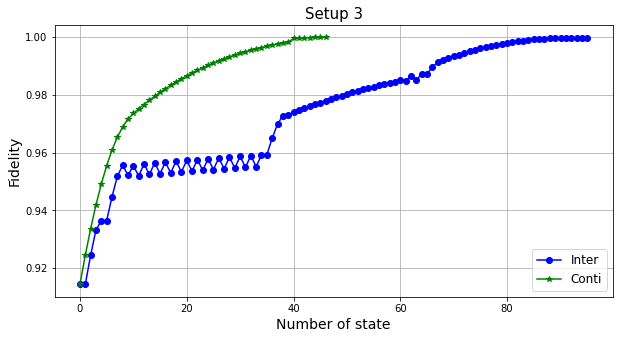

In [136]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, listfidelitiesint, '-o', color='blue',label="Inter")

#####################

# data without intermediary states
xaxis1 = [i for i in range(len(finalestados))]
ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

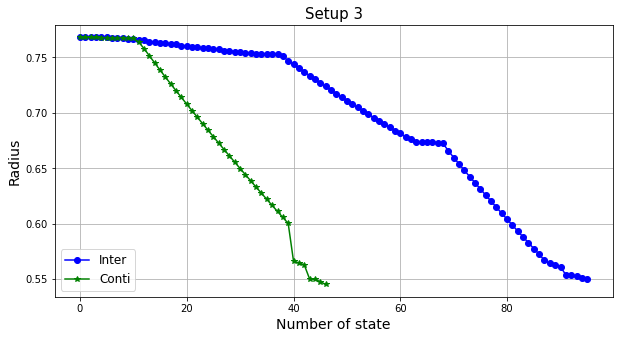

In [137]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,radiusint, '-o', color='blue',label="Inter")
ax.plot(xaxis1, radius, '-*', color='green',label="Conti")

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Radius',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower left')
# show the plot
plt.show()

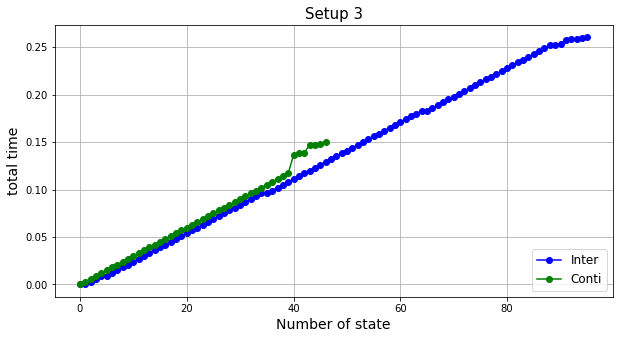

In [138]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,soltimes, '-o', color='blue',label="Inter")
ax.plot(xaxis1,finaltiempotot, '-o', color='green',label="Conti")

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('total time',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

/home/mauro/anaconda3/envs/qucontrolenv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


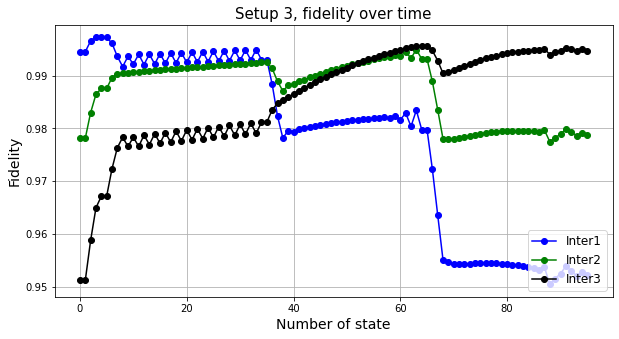

In [139]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, fide_inter_1, '-o', color='blue',label="Inter1")
ax.plot(xaxis, fide_inter_2, '-o', color='green',label="Inter2")
ax.plot(xaxis, fide_inter_3, '-o', color='black',label="Inter3")


#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3, fidelity over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

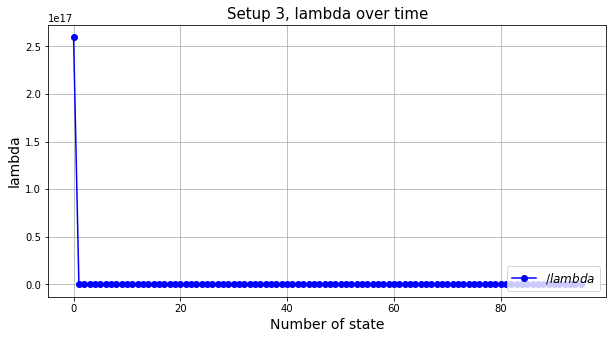

In [140]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, list_lambda, '-o', color='blue',label="$/lambda$")



#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('lambda',fontsize=14)
ax.set_title('Setup 3, lambda over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

In [141]:
list_lambda

[2.59426630347710e+17,
 241.731866935490,
 446.643406789588,
 1299.16531679228,
 1607.99092309703,
 247.994811070802,
 449.466401405568,
 1343.20014744079,
 889.053770434767,
 1036.55610254568,
 1132.13020750324,
 1050.96076700159,
 1045.55864534659,
 1095.02903883870,
 1043.93442905271,
 1065.81512714192,
 1080.73452945266,
 1074.71118224839,
 1072.50431458763,
 1080.22728460876,
 1081.62201986000,
 1076.99580062483,
 1092.51855619012,
 1080.62294492295,
 1096.50145565300,
 1082.40096219930,
 1104.20901479020,
 1083.19886809521,
 1111.29935113700,
 1085.28370110049,
 1117.19202883724,
 1086.80584371639,
 1123.78297490443,
 1088.26229425889,
 1129.96557037617,
 232.876793362729,
 379.395304358200,
 737.133946261140,
 669.351128386034,
 737.728373829247,
 756.426685747581,
 793.808695855729,
 820.747122457694,
 854.671325408163,
 885.727742412802,
 920.900730097295,
 955.318070740758,
 993.012339949200,
 1030.67388345415,
 1071.53652816398,
 1112.54434575789,
 1157.17284173202,
 1201.63